# Setup Inicial

In [1]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random
import os
import inspect
import pathlib
import math

#Essentials

import IPython
import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show
from scipy.optimize import curve_fit

#from objproxies import *

import matplotlib.pyplot as plt

#Qiskit

import qiskit
from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *
from braket.aws import AwsDevice
from braket.devices import Devices
from braket.aws import AwsDevice, AwsQuantumTask

## Mitiq 

from mitiq import zne


%matplotlib widget
#%matplotlib inline

In [2]:
# Backends

provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

# Setup inicial do problema

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

# Criando Circuito Aria - AWS

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

# Criando Circuito Brisbane - IBM

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [44]:
def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
def salvar_obj(obj, filename):
    script_dir = get_current_directory()
    dados_dir = os.path.join(script_dir, 'dados')
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{filename}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

In [5]:

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None, basis_gates = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation) if coupling_map == None and basis_gates == None else Estimator_Aer(backend_options={'noise_model': noise_model, 'coupling_map': coupling_map, 'basis_gates' : basis_gates}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value
 
def fix_circuit_qubits(circuit, driver):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   return new_circuit


# ZNE

In [141]:
def teste_circuit_folding(circuit, noise_factor):
  
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
      
    return n, s

def circuit_folding(circuit, noise_factor):
    
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
    
    circuito_original, circuito = circuit.copy(), circuit.copy()
    
    for a in range(n):
        
        inverse = circuito_original.inverse()
        
        identity = inverse.compose(circuito_original)
        
        circuito = circuito.compose(identity)
    
    if s != 0:
        
        circuito_parcial = QuantumCircuit(*circuito.qregs, *circuito.cregs)
                
        for instr in circuito.data[-s:]:
            
            circuito_parcial.append(instr[0], instr[1], instr[2])
    
        inverse = circuito_parcial.inverse()
        
        identity = inverse.compose(circuito_parcial)
        
        circuito = circuito.compose(identity)
    
    return circuito

def circuit_folding_transpile(circuit, noise_factor, backend):
    
    k = int((d := circuit.depth())*(noise_factor - 1)/2)
    
    n, s = k//d, k%d
    
    circuito_original, circuito = circuit.copy(), circuit.copy()
    
    for a in range(n):
        
        inverse = circuito_original.inverse()
        
        identity = inverse.compose(circuito_original)
        
        circuito = circuito.compose(identity)
    
    if s != 0:
        
        circuito_parcial = QuantumCircuit(*circuito.qregs, *circuito.cregs)
                
        for instr in circuito.data[-s:]:
            
            circuito_parcial.append(instr[0], instr[1], instr[2])
    
        inverse = circuito_parcial.inverse()
        
        identity = inverse.compose(circuito_parcial)
        
        circuito = circuito.compose(identity)
    
    return transpile(circuito, backend, optimization_level=0)


def ZNE(circuit, start = 1, end = 3, points = None, verbose = 0):
    
    if start < 1:
        
        raise ValueError("Start must be greater than 1")
    
    max_points = math.ceil((end - start)/(2/circuit.depth()))
    
    if points == None or points > max_points:
        
        points = max_points

    step = (end - start)/points

    for a in np.arange(start, end, step):
        
        if not verbose:
    
            yield circuit_folding(circuit, a) 
            
        else: 
            
            print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuit, a))[0]}, s:{temp[1]}")
            
            yield [circuit_folding(circuit, a), a]
            
def ZNE_transpile(circuit, backend, start = 1, end = 3, points = None, verbose = 0):
    
    if start < 1:
        
        raise ValueError("Start must be greater than 1")
    
    max_points = math.ceil((end - start)/(2/circuit.depth()))
    
    if points == None or points > max_points:
        
        points = max_points

    step = (end - start)/points

    for a in np.arange(start, end, step):
        
        if not verbose:
    
            yield circuit_folding_transpile(circuit, a, backend) 
            
        else: 
            
            print(f"Lambda = {a}\tn:{(temp := teste_circuit_folding(circuit, a))[0]}, s:{temp[1]}")
            
            yield [circuit_folding_transpile(circuit, a, backend), a]

# Rodando o ZNE Localmente

In [ ]:
#circuito_ibm.draw('mpl')

In [ ]:
zne_circuits = list(ZNE(circuito_ibm, start = 1, end = 2, points = 5, verbose = 1))

Lambda = 1.0	n:0, s:0
Lambda = 1.2	n:0, s:14
Lambda = 1.4	n:0, s:28
Lambda = 1.5999999999999999	n:0, s:42
Lambda = 1.7999999999999998	n:0, s:57


In [ ]:
for a in zne_circuits:
    
    print(a.depth())

143
155
169
187
201


# AWS Braket Provider

In [ ]:
provider = AWSBraketProvider()

## Functions for AWS Backend

In [ ]:
def run_estimator_aws(circuit, driver, backend, shots = 1000, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
      
   #estimator = EstimatorV2(backend = backend, options = {"shots" : shots})
   estimator = EstimatorV2(backend = backend)
   estimator.options.default_shots = shots
   
   #job = estimator.run(circuit, mapper.map(hamiltoniano))
   job = estimator.run([(circuit, mapper.map(hamiltoniano), [])])
   
   return job

In [ ]:
def getData(aria1_task_id):
    # recover quantum task
    task_load = AwsQuantumTask(arn=aria1_task_id)

    # print status
    status = task_load.state()
    print('Status of (reconstructed) quantum task:', status)
    
    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        aria1_results = task_load.result()

        # get all metadata of submitted quantum task
        metadata = task_load.metadata()
        
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        
        # print example metadata
        # print("{} shots taken on machine {}.\n".format(shots, machine))

        # get measurement counts
        aria1_counts = dict(sorted(aria1_results.measurement_counts.items()))
        print('Measurement counts:', aria1_counts)
        print('Expected value:', aria1_results.values[0])
        
        return aria1_results.values[0]

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your quantum task is in terminal status, but has not completed.')
        return 0
    else:
        # print current status
        print('Sorry, your quantum task is still being processed and has not been finalized yet.')
        return 0

In [ ]:
j_sv1_Estimator_circuito = run_estimator_aws(circuito, es_problem, sv1, 2000)

In [ ]:
task_id = j_sv1_Estimator_circuito.job_id()

AwsQuantumTask(arn=task_id).result()


# Utilizando o Backend da IBM

In [40]:
def run_estimator_ibm(circuit, driver, backend, shots = 1000, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
      
   #estimator = EstimatorV2(backend = backend, options = {"shots" : shots})
   estimator = EstimatorV2(backend = backend)
   estimator.options.default_shots = shots
   
   #job = estimator.run(circuit, mapper.map(hamiltoniano))
   job = estimator.run([(circuit, mapper.map(hamiltoniano), [])])
   
   return job

In [8]:
service = QiskitRuntimeService()
kyoto_backend = service.backend('ibm_kyoto')
brisbane_backend = service.backend('ibm_brisbane')

In [9]:
circuito_ibm_kyoto = fix_circuit_qubits(transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), kyoto_backend), es_problem)

circuito_ibm_brisbane = fix_circuit_qubits(transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), brisbane_backend), es_problem)

In [12]:
#id_kyoto_Estimator_original = "ctna7mpx7b5g0080gnwg"
#id_brisbane_Estimator_original = "ctnahszx7b5g0080gpy0"

#salvar("id_kyoto_Estimator_original")
#salvar("id_brisbane_Estimator_original")

id_kyoto_Estimator_original = abrir("id_kyoto_Estimator_original")
id_brisbane_Estimator_original = abrir("id_brisbane_Estimator_original")

In [18]:
job_result_kyoto = service.job(id_kyoto_Estimator_original).result()
job_result_brisbane = service.job(id_brisbane_Estimator_original).result()

for idx, pub_result in enumerate(job_result_kyoto):
    print(f"Expectation value original circuit [Kyoto]: {pub_result.data.evs}")
    
for idx, pub_result in enumerate(job_result_brisbane):
    print(f"Expectation values original circuit [Brisbane]: {pub_result.data.evs}")

Expectation value original circuit [Kyoto]: -1.0998333721520073
Expectation values original circuit [Brisbane]: -0.8618584610707686


In [143]:
#zne_circuits_brisbane = list(ZNE_transpile(circuito_ibm_brisbane, brisbane_backend, start = 1, end = 3, points = 10, verbose = 1))
#salvar("zne_circuits_brisbane")

zne_circuits_brisbane = abrir("zne_circuits_brisbane")

In [144]:
zne_circuits_brisbane_circuitos = list(a[0] for a in zne_circuits_brisbane)
zne_circuits_brisbane_lambda = list(a[1] for a in zne_circuits_brisbane)

In [146]:
for index, (a, b) in enumerate(zne_circuits_brisbane):
    
    print(index, a.depth(), b)

0 143 1.0
1 163 1.2
2 185 1.4
3 209 1.5999999999999999
4 233 1.7999999999999998
5 259 1.9999999999999998
6 283 2.1999999999999997
7 307 2.3999999999999995
8 337 2.5999999999999996
9 361 2.8


In [157]:
with Session(service=service, backend=brisbane_backend) as session:

    for index, (circuito_zne, lambda_value) in enumerate(zne_circuits_brisbane):
        
        ultimo_index = 6
        
        if index <= ultimo_index:
            continue
        
        job = run_estimator_ibm(circuito_zne, es_problem, brisbane_backend, 2000)
        
        job_id = job.job_id()

        salvar_obj(job_id, f"id_brisbane_Estimator_zne_1_{index}")
        
        print(f"Index: {index} \t Lambda : {lambda_value} \t Task ID: {job_id}")

Index: 7 	 Lambda : 2.3999999999999995 	 Task ID: ctqvrtb6g3rg0087qbsg
Index: 8 	 Lambda : 2.5999999999999996 	 Task ID: ctqvrv34gjh0008ptxx0
Index: 9 	 Lambda : 2.8 	 Task ID: ctqvrvk4gzyg008zs7jg


In [ ]:
import qiskit.qasm2

print(qiskit.qasm2.dumps(zne_circuits_brisbane[1][0]))

In [139]:
qc = QuantumCircuit(1)
qc.append(SXdgGate(), [0])
qc = circuit_folding(qc, 10)
print(qc.draw())

print(fix_circuit_qubits(transpile(qc, brisbane_backend, optimization_level=0), es_problem).draw())

   ┌──────┐┌────┐┌──────┐┌────┐┌──────┐┌────┐┌──────┐┌────┐┌──────┐
q: ┤ √Xdg ├┤ √X ├┤ √Xdg ├┤ √X ├┤ √Xdg ├┤ √X ├┤ √Xdg ├┤ √X ├┤ √Xdg ├
   └──────┘└────┘└──────┘└────┘└──────┘└────┘└──────┘└────┘└──────┘
     ┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐┌─────────┐»
q_0: ┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├»
     └─────────┘└─────────┘└────┘└─────────┘└─────────┘└────┘└─────────┘»
q_1: ───────────────────────────────────────────────────────────────────»
                                                                        »
q_2: ───────────────────────────────────────────────────────────────────»
                                                                        »
q_3: ───────────────────────────────────────────────────────────────────»
                                                                        »
«     ┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐┌─────────┐┌─────────┐┌────┐»
«q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(π/2) ├┤ √X

In [164]:
# zne_circuits_brisbane_results = []

# for index, (circuito_zne, lambda_value) in enumerate(zne_circuits_brisbane):
    
#     job_id = abrir(f"id_brisbane_Estimator_zne_1_{index}")
    
#     job_result = service.job(job_id).result()[0].data.evs

#     zne_circuits_brisbane_results.append([job_result, lambda_value])
    
#     print(f"Index: {index} \t Lambda : {lambda_value} \t Result: {job_result}")
    
# salvar_obj(zne_circuits_brisbane_results, "zne_circuits_brisbane_results")

zne_circuits_brisbane_results = abrir("zne_circuits_brisbane_results")

In [167]:
zne_circuits_brisbane_results

[[array(-0.89010345), 1.0],
 [array(-0.96758807), 1.2],
 [array(-0.97032439), 1.4],
 [array(-1.01645243), 1.5999999999999999],
 [array(-0.90152596), 1.7999999999999998],
 [array(-0.83898192), 1.9999999999999998],
 [array(-0.90094527), 2.1999999999999997],
 [array(-0.85428377), 2.3999999999999995],
 [array(-0.90293375), 2.5999999999999996],
 [array(-0.82892087), 2.8]]

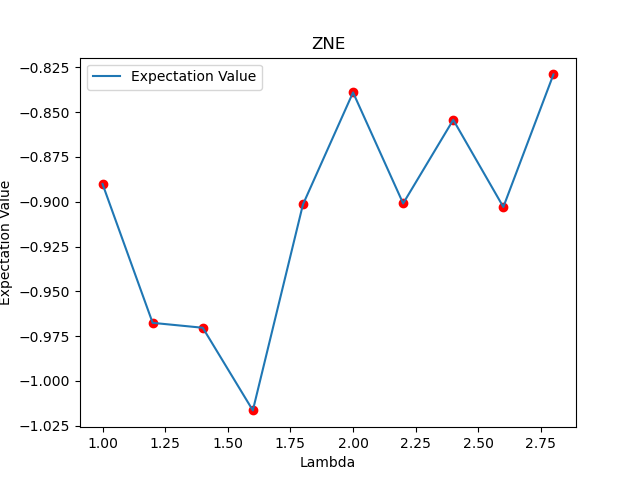

In [171]:
plt.figure()

plt.plot([a[1] for a in zne_circuits_brisbane_results], [a[0].item() for a in zne_circuits_brisbane_results], label = "Expectation Value")
plt.scatter([a[1] for a in zne_circuits_brisbane_results], [a[0].item() for a in zne_circuits_brisbane_results], c='red')

plt.xlabel("Lambda")
plt.ylabel("Expectation Value")
plt.title("ZNE")
plt.legend()
plt.show()

In [172]:
#zne_circuits_brisbane_2 = list(ZNE_transpile(circuito_ibm_brisbane, brisbane_backend, start = 1.1, end = 10, points = 20, verbose = 1))
#salvar("zne_circuits_brisbane_2")

zne_circuits_brisbane = abrir("zne_circuits_brisbane_2")

Lambda = 1.1	n:0, s:7
Lambda = 1.5450000000000002	n:0, s:38
Lambda = 1.9900000000000002	n:0, s:70
Lambda = 2.4350000000000005	n:0, s:102
Lambda = 2.8800000000000003	n:0, s:134
Lambda = 3.3250000000000006	n:1, s:23
Lambda = 3.7700000000000005	n:1, s:55
Lambda = 4.215	n:1, s:86
Lambda = 4.66	n:1, s:118
Lambda = 5.105	n:2, s:7
Lambda = 5.550000000000001	n:2, s:39
Lambda = 5.995000000000001	n:2, s:71
Lambda = 6.440000000000001	n:2, s:102
Lambda = 6.885000000000002	n:2, s:134
Lambda = 7.33	n:3, s:23
Lambda = 7.775	n:3, s:55
Lambda = 8.22	n:3, s:87
Lambda = 8.665000000000001	n:3, s:119
Lambda = 9.110000000000001	n:4, s:7
Lambda = 9.555000000000001	n:4, s:39


In [173]:
for index, (a, b) in enumerate(zne_circuits_brisbane_2):
    
    print(index, a.depth(), b)

0 155 1.1
1 203 1.5450000000000002
2 259 1.9900000000000002
3 309 2.4350000000000005
4 375 2.8800000000000003
5 597 3.3250000000000006
6 651 3.7700000000000005
7 711 4.215
8 765 4.66
9 999 5.105
10 1049 5.550000000000001
11 1103 5.995000000000001
12 1153 6.440000000000001
13 1219 6.885000000000002
14 1441 7.33
15 1495 7.775
16 1555 8.22
17 1611 8.665000000000001
18 1843 9.110000000000001
19 1893 9.555000000000001


In [175]:
brisbane_backend.properties()

TypeError: 'BackendProperties' object is not iterable